Python implementation of the Image Resolution Estimation algorithm by A. Descloux et al. 

>Descloux, A., K. S. Grußmayer, et A. Radenovic. _Parameter-Free Image Resolution Estimation Based on Decorrelation Analysis_. Nature Methods 16, nᵒ 9 (septembre 2019): 918‑24. https://doi.org/10.1038/s41592-019-0515-7.

Original source code in matlab™ and ImageJ plugin are available [here](https://github.com/Ades91/ImDecorr)


In [56]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.signal import general_gaussian, find_peaks

from scipy.fft import fft2

from scipy.fft import fftshift, ifft2, ifftshift

from skimage import img_as_float

In [220]:
# apodImRect.m
def apodise(image, border, order=8):
    """
    Parameters
    ----------
    
    image: np.ndarray 
    border: int, the size of the boreder in pixels
    
    Note
    ----
    The image is assumed to be of float datatype, no datatype management
    is performed.
    
    This is different from the original apodistation method,
    which multiplied the image borders by a quater of a sine.
    """
    # https://stackoverflow.com/questions/46211487/apodization-mask-for-fast-fourier-transforms-in-python
    nx, ny = image.shape
    # Define a general Gaussian in 2D as outer product of the function with itself
    window = np.outer(
        general_gaussian(nx, 8, nx//2-border),
        general_gaussian(ny, 8, ny//2-border))
    ap_image = window*image
    
    return ap_image


In [221]:
def test_apodise():

    image = np.random.random((800, 600))
    ap_image = apodise(image, 60)
    assert ap_image.shape == image.shape
    
    assert ap_image[:, 0].mean() < 1e-3
    assert ap_image[0, :].mean() < 1e-3
    np.testing.assert_array_almost_equal(
        ap_image[400:410, 300:310],
        image[400:410, 300:310], decimal=3
    )
        

In [222]:
def get_correlation_coefficient(im_fft1, im_fft2, c1=None, c2=None):
    if c1 is None:
        c1 = np.linalg.norm(im_fft1)
    if c2 is None:
        c2 = np.linalg.norm(im_fft2)
    return (im_fft1 * im_fft2.conjugate()).real.sum() / (c1*c2)


In [223]:
def test_cor_coeff():
    im1 = np.random.random([1000, 1000])
    im2 = np.random.random([1000, 1000])
    im_fft1 = fft2(im1)
    im_fft2 = fft2(im2)


    np.testing.assert_approx_equal(
        get_correlation_coefficient(im_fft1, im_fft2),
        0.75, significant=2
    )
    np.testing.assert_approx_equal(
        get_correlation_coefficient(im_fft1, im_fft1),
        1.0, significant=5
    )
    np.testing.assert_approx_equal(
        get_correlation_coefficient(im_fft1, fft2(1 - im1)),
        0.5, significant=3
    )

test_cor_coeff()


%  im        	2D image to be analyzedthreshold
%  r           	Fourier space sampling of the analysis (default: r = linspace(0,1,50)
%  Ng			Number of high-pass filtering (default: Ng = 10)
                                                        


In [224]:
!ls ../../samples/

organ-of-corti.tif


In [225]:
from skimage.io import imread

In [226]:
corti = img_as_float(imread('../../samples/organ-of-corti.tif'))

In [227]:
corti = corti[0, ..., 0]

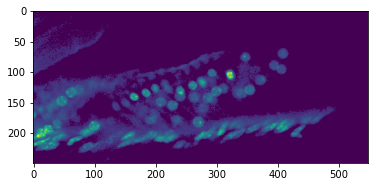

In [228]:
plt.imshow(corti)

In [229]:
corti.shape

(249, 548)

In [250]:

image = apodise(corti, 30, order=8)

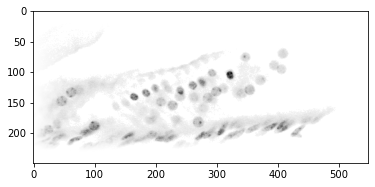

In [251]:
plt.imshow(image, cmap='Greys')

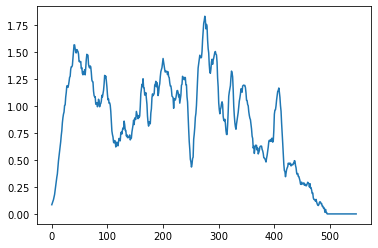

In [252]:
plt.plot(image.sum(axis=0))

In [253]:
from scipy.ndimage import gaussian_filter


#(input, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
Nr = 100
pic_threshold = 1e-5

radius = np.linspace(1/Nr, 1, Nr)
nx, ny = image.shape
# odd number of pixels
nx, ny = nx - (1 - nx%2), ny - (1 - ny%2)
image = image[:nx, :ny]

xx, yy = np.meshgrid(np.linspace(-1, 1, ny), np.linspace(-1, 1, nx))
I = fftshift(fft2(fftshift(image)))
I /= np.abs(I)
I[~np.isfinite(I)] = 0

dist2 = (xx**2 + yy**2)
mask0 = dist2 < 1.

# restric all the analysis to the region r <= 1
I *= mask0

image_bar = (image - image.mean())/image.std()
Ik = fftshift(fft2(fftshift(image_bar)))
Ik *= mask0

imr = ifftshift(
    ifft2(
        ifftshift(Ik)
    )
).real

imt = imr
Ir = mask0*fftshift(fft2(fftshift(imt)))

# possible optim:
# Ir.ravel().imag[:(nx*ny)//2] == -Ir.ravel().imag[:-(nx*ny)//2:-1]

c = np.linalg.norm(Ir)
d0 = np.array([
    get_correlation_coefficient(Ir, (dist2 < rt)*I, c1=c)
    for rt in radius
])

def find_max_corr(d, threshold):
    pos, _ = find_peaks(d, threshold=threshold)
    if not pos.size:
        pos = -1
    elif pos.size == 1:
        pos = pos[0]
    else:
        warnings.warn("Equivocal value for the correlation maximum")
        ds = d[pos]
        top = ds.argmax()
        pos = pos[top]
    return pos

pos0 = find_max_corr(d0, pic_threshold)
snr0 = d0[pos]
res0 = radius[pos]


# Automatic search of best geometric mean (?)
gMax = 2/res0
Ng = 10

dg = []
maxes = []
snrs = []
res = []
gauss_freqs = np.logspace(np.log10(gMax), np.log10(0.15), Ng)

for width in gauss_freqs:
    imt = imr - gaussian_filter(imt, width)
    Ir = mask0 * fftshift(fft2(fftshift(imt)));
    c = np.linalg.norm(Ir)
    d = np.array([
            get_correlation_coefficient(Ir, (dist2 < rt)*I, c1=c)
            for rt in radius
        ])
    dg.append(d)
    pos = find_max_corr(d, pic_threshold)
    maxes.append(pos)
    snrs.append(d[pos])
    res.append(radius[pos])


/home/guillaume/miniconda3/envs/ijpy/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Equivocal value for the correlation maximum


In [254]:
snrs = np.array(snrs)
maxes = np.array(maxes)
res = np.array(res)

In [255]:
snrs

array([0.79763413, 0.26088614, 0.78566308, 0.23573492, 0.62167291,
       0.19378834, 0.66952452, 0.18871128, 0.66993007, 0.18871026])

In [256]:
maxes

array([-1, 75, -1, -1, 10, -1,  9, -1,  9, -1])

In [257]:
res

array([1.  , 0.76, 1.  , 1.  , 0.11, 1.  , 0.1 , 1.  , 0.1 , 1.  ])

In [258]:
dg = np.array(dg)

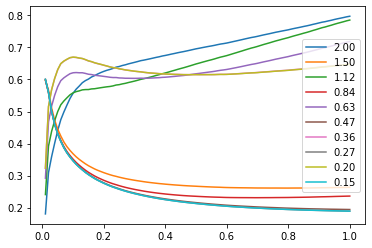

In [259]:
fig, ax = plt.subplots()
for d, freq in zip(dg, gauss_freqs):
    
    ax.plot(radius, d, label=f'{freq:.2f}')

ax.legend()

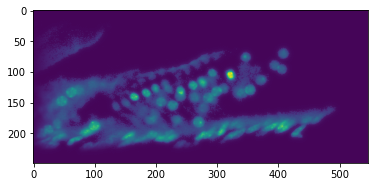

In [260]:
plt.imshow(imt)

```octave
% automatic search of best geometric mean
g = exp(linspace(log(gMax),log(0.15),Ng));
d = []; kc = []; SNR = []; gm = []; dc = 1;

for refin = 1:2 % two step refinement
for h = 1:length(g)
    imt = imr - imgaussfilt(imr,g(h));
    Ir = mask0.*fftshift(fftn(fftshift(imt)));
    Ir = Ir(1:(end-1)/2);
    c = sqrt(sum(sum(abs(Ir).^2)));
    for k = length(r):-1:1
        rt = r(k);
        mask  = X.^2 + Y.^2 < rt^2;
        temp = mask.*I;
        temp = temp(1:(end-1)/2); % remove the mean
%         cc = sum(sum(abs(Ir.*temp)))/(c.*sqrt(sum(sum(abs(temp).^2)))); % compute the correlation coeficient
        cc = getCorrcoef(Ir,temp,c);
        if isnan(cc); cc = 0; end
        d(k,dc) = gather(cc); % gather if input image is gpuArray
        count = count+1;
        if figID
            waitbar(0.1 + 0.9*count/(Nr*Ng*2),hwait);
        end
    end
    dc = dc + 1;
    [ind,snr] = getDcorrMax(d(:,end));
    kc(end+1) = r(ind);
    SNR(end+1) = snr;
    gm(end+1) = sqrt(snr*r(ind)); % 
end
```

In [64]:
res0

0.012

In [65]:
snr0

0.6116782291903357

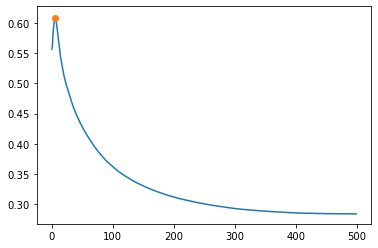

In [66]:
fig, ax = plt.subplots()
ax.plot(d0)
ax.plot(pos, d0[pos], 'o')

```octave
function [ind,A] = getDcorrMax(d)

[A,ind] = max(d);
t = d;
% arbitrary peak significance parameter imposed by numerical noise
% this becomes relevant especially when working with post-processed data
dt = 0.001;

while ind == length(t)
    t(end) = [];
    if isempty(t)
        A = 0;
        ind = 1;
    else
        [A,ind] = max(t);
        % check if the peak is significantly larger than the former minimum
        if t(ind) - min(d(ind:end)) > dt 
            break
        else
            t(ind) = min(d(ind:end));
            ind = length(t);
        end
    end
```     


```octave
[X,Y] = meshgrid(linspace(-1,1,size(im,2)),linspace(-1,1,size(im,1)));
Nr = length(r);

I = fftshift(fftn(fftshift(im))); I = I./abs(I); I(isinf(I)) = 0; I(isnan(I)) = 0;
mask0 = X.^2 + Y.^2 < 1^2;
I = mask0.*I; % restric all the analysis to the region r == 1

Ik = mask0.*fftshift(fftn(fftshift((im-mean(im(:)))/std(im(:)))));
imr = real(ifftshift(ifftn(ifftshift(Ik))));
```

In [47]:
fftshift(image)

array([[0.67074799, 0.83671364, 0.25276363, ..., 0.19642213, 0.58379736,
        0.21906116],
       [0.59398047, 0.82944432, 0.34915216, ..., 0.71289157, 0.84588396,
        0.67555132],
       [0.63400142, 0.27897325, 0.96001238, ..., 0.22407383, 0.69553334,
        0.47816803],
       ...,
       [0.65119477, 0.07653379, 0.48667962, ..., 0.57571926, 0.55755134,
        0.03168877],
       [0.71385308, 0.37119132, 0.21414192, ..., 0.67157937, 0.42736937,
        0.84743655],
       [0.70361153, 0.68760876, 0.4406447 , ..., 0.16073305, 0.19318633,
        0.85689938]])